In [22]:
# Connect <colab to google drive
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import modules

In [23]:
import pandas as pd
import os 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings 
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore') 
%matplotlib inline 
import tensorflow as tf 
# from keras_preprocessing.image import load_img , img_to_array
from keras import Input
from keras.layers import Dense, Conv2D, Dropout,Flatten, MaxPooling2D,Input
from PIL import Image 

Load the data set

In [ ]:
# Extract Dataset and Organize files

#BASE_DIR='/content/drive/MyDrive/UTKFace' #Colab
BASE_DIR = 'UTKFace'
filepath = os.path.join(BASE_DIR, 'UTKFace.tar.gz')
!tar -xzvf $filepath -C $BASE_DIR
!rm $filepath

filepath = os.path.join(BASE_DIR, 'crop_part1.tar.gz')
!tar -xzvf $filepath -C $BASE_DIR
!mv  /content/drive/MyDrive/selected_dataset/crop_part1/* /content/drive/MyDrive/selected_dataset/UTKFace/
!rm $filepath
!rm -r /content/drive/MyDrive/selected_dataset/crop_part1/

In [24]:
# Mapping ages to  5 Classes

def age_to_class( age ):
  age_class = None
  # 0 (0-20)
  if 0 <= age <= 20:
    age_class = 0
  # 1 (20-40)
  if 20 < age <= 40:
    age_class = 1
  # 2 (40-60)
  if 40 < age <= 60:
    age_class = 2
  # 3 (40-60)
  if 60 < age <= 80:
    age_class = 3
  # 3 (80+)
  if age > 80:
    age_class = 4
  return age_class

# map age classes for age gaps
age_dict = {0:'0-10', 1:'10-20',2:'20-35', 3:'35-50', 4:'50+'}

def decode_age_label(age_id):
  return age_dict[int(age_id)]



In [25]:
# Load Data from files
BASE_DIR='/content/drive/MyDrive/UTKFace/'

image_paths=[]
age_labels=[]
gender_labels=[]
age_class=[]

for filename in tqdm (os.listdir(BASE_DIR)):
  imagepath=os.path.join(BASE_DIR,filename)
  temp=filename.split('_')
  age=int(temp[0])
  gender=int(temp[1])
  image_paths.append(imagepath)
  age_labels.append(age)
  gender_labels.append(gender)
  age_class.append(age_to_class(age))

  0%|          | 0/23709 [00:00<?, ?it/s]

In [26]:
# Convert into dataframe 
df=pd.DataFrame()
df['image'],df['age'],df['gender'], df['age_class']=image_paths,age_labels,gender_labels, age_class
df
# Map labels for gender 
gender_dic={0:'Male',1:"Female"}


Exploratory Data Anlysis

(200, 200, 3)


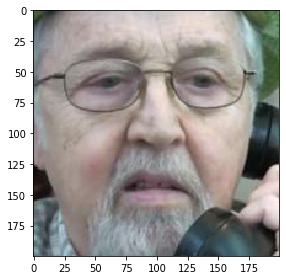

In [17]:
#Explore Dataset and Extract Hog Features
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure


#reading the image
img = imread(df['image'][0])
imshow(img)
print(img.shape)


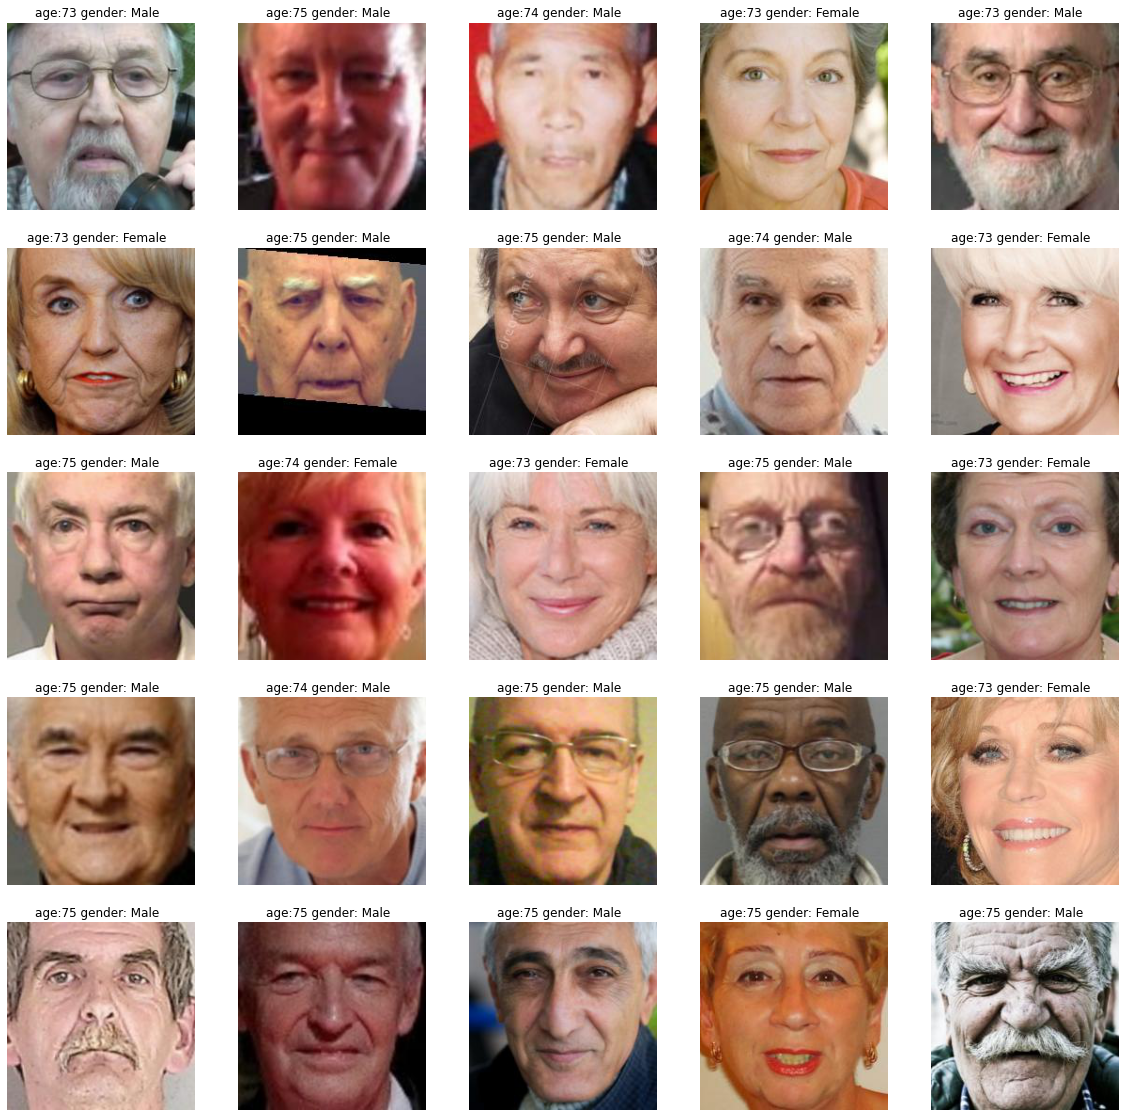

In [ ]:
# To display grid of images 
plt.figure(figsize=(20,20)) 
files= df.iloc[:25] #
for index,file,age ,gender,a in files.itertuples():
  plt.subplot(5,5,index+1)
  img=load_img(file)
  img=np.array(img)
  plt.imshow(img)
  plt.title(f'age:{age} gender: {gender_dic[gender]}  ')
  plt.axis('off')


(128, 64)


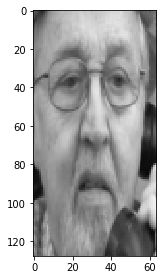

In [16]:
# Resize and grayscale for preparing to Hog

img = imread(df['image'][0], as_gray=True)

resized_img = resize(img, (128,64)) 
imshow(resized_img) 
print(resized_img.shape)

In [19]:
#creating hog features 
fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True, multichannel=False)
fd.shape

(3780,)

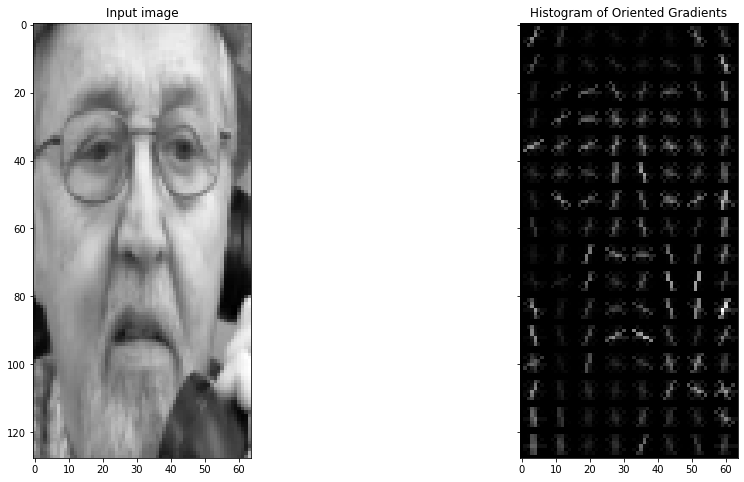

In [20]:
# Visualizing the HOG Features
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True) 

ax1.imshow(resized_img, cmap=plt.cm.gray) 
ax1.set_title('Input image') 

# Rescale histogram for better display 
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10)) 

ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray) 
ax2.set_title('Histogram of Oriented Gradients')

plt.show()

In [ ]:
#we convert image to grayscale because rgb has 3d
# 1 gray , resize, array

def extract_features (images):
  features=[]
  for image in tqdm(images):

    img = imread(image, as_gray=True)
    resized_img = resize(img, (128,64)) 
    #creating hog features 
    fd = hog(resized_img, orientations=9, pixels_per_cell=(8, 8), 
                        cells_per_block=(2, 2), visualize=False, multichannel=False)
    
    features.append(fd)

  features=np.array(features)
  return features


In [ ]:
X=extract_features(df['image'])
X

  0%|          | 0/23709 [00:00<?, ?it/s]

array([[0.35694872, 0.35694872, 0.35694872, ..., 0.        , 0.18818576,
        0.26534753],
       [0.38232238, 0.14720278, 0.0064479 , ..., 0.00097827, 0.00961818,
        0.02826496],
       [0.44981466, 0.00698626, 0.01060515, ..., 0.01005184, 0.02293666,
        0.04801088],
       ...,
       [0.30611969, 0.06544415, 0.04536426, ..., 0.00612571, 0.00321838,
        0.01315757],
       [0.34709577, 0.14757365, 0.03295118, ..., 0.02228363, 0.00406202,
        0.01608974],
       [0.34074032, 0.34074032, 0.17074649, ..., 0.05064417, 0.0240212 ,
        0.27394107]])

In [27]:
saved_features= '/content/drive/MyDrive/feats_hog.csv'
if os.path.isfile(saved_features):
  dfff = pd.read_csv('/content/drive/MyDrive/feats_hog.csv')
else:
  dff= pd.DataFrame(X.reshape(X.shape[0],-1))
  dff.to_csv(saved_features, index=False)

# !cp feats_hog.csv /content/drive/MyDrive/

In [28]:
data = pd.concat([df,dfff],axis=1)
data

,image,age,gender,age_class,0,1,2,3,4,5,...,3770,3771,3772,3773,3774,3775,3776,3777,3778,3779
0,/content/drive/MyDrive/UTKFace/73_0_0_20170111...,73,0,3,0.356949,0.356949,0.356949,0.060855,0.136110,0.017881,...,0.294889,0.294889,0.195296,0.013691,0.006072,0.251739,0.000000,0.000000,0.188186,0.265348
1,/content/drive/MyDrive/UTKFace/75_0_0_20170111...,75,0,3,0.382322,0.147203,0.006448,0.010930,0.021741,0.007640,...,0.261040,0.034960,0.011815,0.008196,0.008650,0.006593,0.006946,0.000978,0.009618,0.028265
2,/content/drive/MyDrive/UTKFace/74_0_2_20170105...,74,0,3,0.449815,0.006986,0.010605,0.003054,0.026519,0.003694,...,0.169816,0.036636,0.012276,0.005389,0.001165,0.017359,0.008321,0.010052,0.022937,0.048011
3,/content/drive/MyDrive/UTKFace/73_1_0_20170110...,73,1,3,0.321075,0.124321,0.138591,0.122311,0.128382,0.042290,...,0.195167,0.239136,0.050469,0.011968,0.040271,0.063929,0.042342,0.135541,0.185322,0.093622
4,/content/drive/MyDrive/UTKFace/73_0_0_20170104...,73,0,3,0.360048,0.000000,0.016427,0.007321,0.086946,0.000000,...,0.119767,0.291860,0.121493,0.039849,0.004047,0.020358,0.020344,0.002155,0.003369,0.071025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23704,/content/drive/MyDrive/UTKFace/22_1_0_20170112...,22,1,1,0.106519,0.254030,0.254030,0.118302,0.045435,0.008005,...,0.569762,0.044638,0.005961,0.000000,0.000003,0.007109,0.000000,0.003250,0.002414,0.032301
23705,/content/drive/MyDrive/UTKFace/27_1_3_20170117...,27,1,1,0.371871,0.303550,0.038220,0.040972,0.050748,0.000000,...,0.000000,0.305042,0.082310,0.288517,0.000000,0.305042,0.060632,0.043102,0.104824,0.305042
23706,/content/drive/MyDrive/UTKFace/51_0_1_20170117...,51,0,2,0.306120,0.065444,0.045364,0.072973,0.120890,0.000000,...,0.063194,0.342722,0.357916,0.037214,0.000000,0.075583,0.007069,0.006126,0.003218,0.013158
23707,/content/drive/MyDrive/UTKFace/29_0_1_20170117...,29,0,1,0.347096,0.147574,0.032951,0.000000,0.022861,0.000000,...,0.373602,0.053304,0.025265,0.015659,0.031969,0.042728,0.015203,0.022284,0.004062,0.016090


In [29]:
# Train-Test Split
from sklearn.utils import shuffle
data = shuffle(data)


X= data.iloc[:,4:]
Y_age= np.array(data['age_class'][:])
from sklearn.model_selection import train_test_split
X, X_test, y, y_test = train_test_split(X, Y_age, test_size = 0.2)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)
print("Training examples", X_train.shape[0])
print("Validation examples", X_val.shape[0])
print("Testing examples", X_test.shape[0])

(18967, 3780)


In [30]:
# Fitting SVM
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 42)
classifier.fit(X_train, y_train)
print("training Accuracy", classifier.score(X_train, y_train))
print("Validation Accuracy", classifier.score(X_val, y_val))

SVC(random_state=42)

In [31]:
#Model accuracy
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix

y_pred = classifier.predict(X_test) 
print ("Accuracy : ", accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cm

Accuracy :  0.7442007591733446


array([[ 716,  265,    9,    0,    1],
       [  40, 2231,  150,    8,    0],
       [   6,  365,  403,   52,    2],
       [   3,   48,  166,  157,    9],
       [   0,    5,   19,   65,   22]])

In [32]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.72      0.82       991
           1       0.77      0.92      0.84      2429
           2       0.54      0.49      0.51       828
           3       0.56      0.41      0.47       383
           4       0.65      0.20      0.30       111

    accuracy                           0.74      4742
   macro avg       0.69      0.55      0.59      4742
weighted avg       0.74      0.74      0.73      4742



In [34]:
y_pred

array([2, 1, 1, ..., 1, 0, 1])

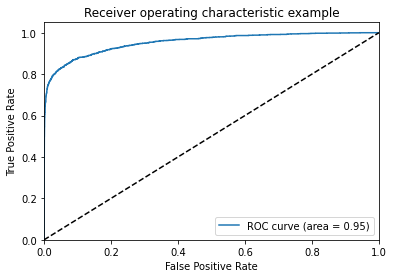

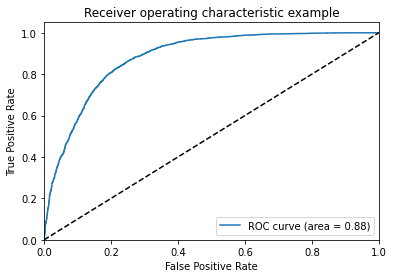

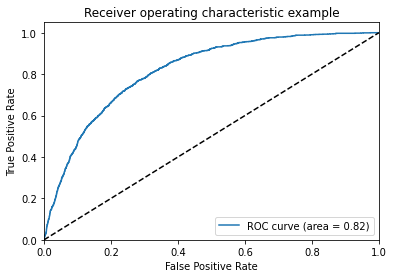

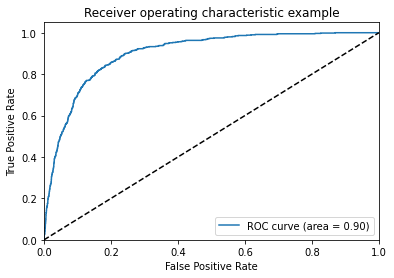

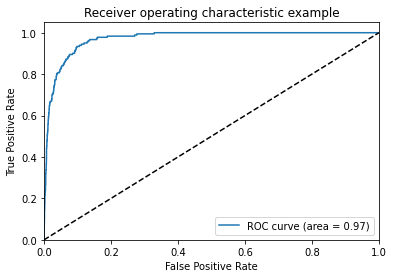

In [35]:
# ROC Curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
X= data.iloc[:,4:]
y= np.array(data['age_class'][:])
y = label_binarize(y, classes=[0,1,2,3,4])
n_classes = 5

# shuffle and split training and test sets
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=0.33, random_state=0)

# classifier
clf = OneVsRestClassifier(SVC(random_state=42))
y_score = clf.fit(X_train, y_train).decision_function(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
# defining parameter range
param_grid = {'C': [0.1, 10, 100 ], 
              'gamma': [1, 0.1, 0.01],
              'kernel': ['rbf']} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.507 total time=  11.7s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.507 total time=  10.9s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.510 total time=  11.4s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.510 total time=  10.7s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.510 total time=  11.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.507 total time=  11.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.507 total time=  11.1s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.510 total time=  13.3s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.510 total time=  11.2s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.510 total time=  11.1s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.507 total time=   7.3s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf;,

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 10, 100], 'gamma': [1, 0.1, 0.01],
                         'kernel': ['rbf']},
             verbose=3)

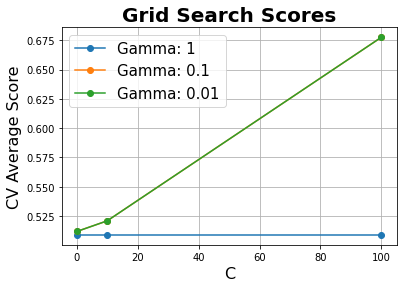

In [ ]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

# Calling Method 
plot_grid_search(grid.cv_results_, param_grid['C'], param_grid['gamma'], 'C', 'Gamma')
